### The Effect of Class Imbalance

In [1]:
library(DWD)
data(ticdata)
# ticdata <- read.csv("ticdata.csv")

Loading required package: Matrix



noinsurance   insurance 
 0.94033802  0.05966198 

Warning message in barchart.table(table(x), data, ...):
"explicit 'data' specification ignored"

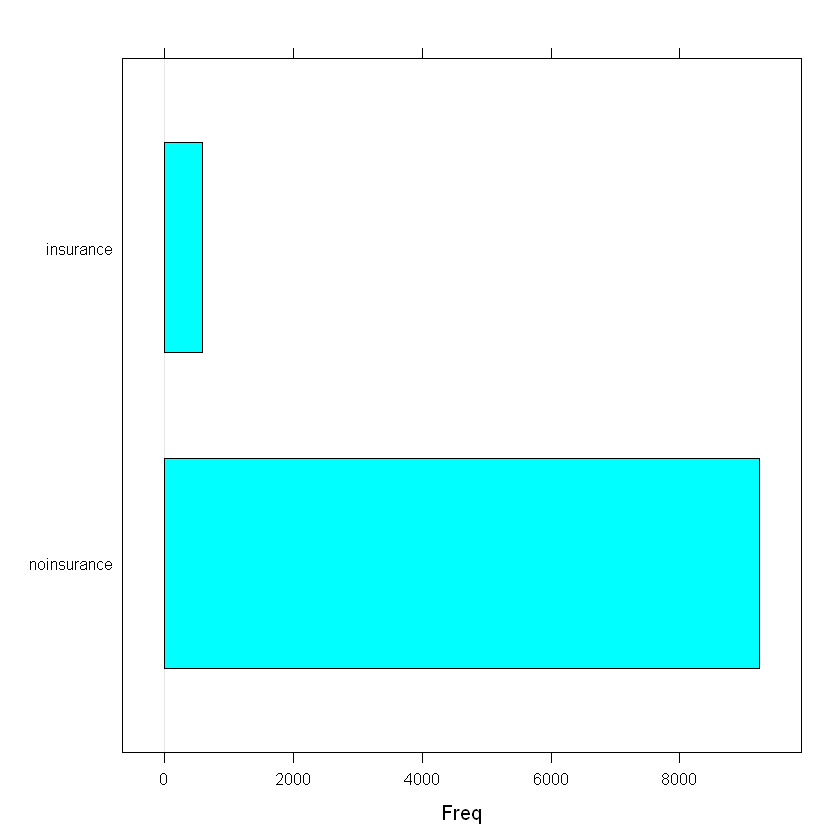

In [15]:
prop.table(table(ticdata$CARAVAN ))
library(lattice)
barchart(ticdata$CARAVAN,data=ticdata)

In [16]:
isOrdered <- unlist(lapply(ticdata, function(x) any(class(x) == "ordered")))

recodeLevels <- function(x)
  {
    x <- gsub("f ", "", as.character(x))
    x <- gsub(" - ", "_to_", x)
    x <- gsub("-", "_to_", x)
    x <- gsub("%", "", x)
    x <- gsub("?", "Unk", x, fixed = TRUE)
    x <- gsub("[,'\\(\\)]", "", x)
    x <- gsub(" ", "_", x)
    factor(paste("_", x, sep = ""))
  }

convertCols <- c("STYPE", "MGEMLEEF", "MOSHOOFD",
                 names(isOrdered)[isOrdered])

for(i in convertCols) ticdata[,i] <- factor(gsub(" ", "0",format(as.numeric(ticdata[,i]))))

ticdata$CARAVAN <- factor(as.character(ticdata$CARAVAN),
                          levels = rev(levels(ticdata$CARAVAN)))

In [17]:
str(ticdata)

'data.frame':	9822 obs. of  86 variables:
 $ STYPE   : Factor w/ 39 levels "01","02","03",..: 15 20 20 21 11 36 13 15 15 7 ...
 $ MAANTHUI: num  1 1 1 1 1 1 2 1 1 2 ...
 $ MGEMOMV : num  3 2 2 3 4 2 3 2 2 3 ...
 $ MGEMLEEF: Factor w/ 6 levels "1","2","3","4",..: 2 2 2 3 2 1 2 3 4 3 ...
 $ MOSHOOFD: Factor w/ 10 levels "01","02","03",..: 6 6 6 1 7 8 3 6 6 1 ...
 $ MGODRK  : Factor w/ 10 levels "01","02","03",..: 1 2 1 3 2 1 3 1 1 4 ...
 $ MGODPR  : Factor w/ 10 levels "01","02","03",..: 6 5 5 4 5 6 3 8 2 6 ...
 $ MGODOV  : Factor w/ 6 levels "1","2","3","4",..: 2 2 3 3 2 1 1 1 4 1 ...
 $ MGODGE  : Factor w/ 10 levels "01","02","03",..: 4 5 5 5 5 6 6 3 7 3 ...
 $ MRELGE  : Factor w/ 10 levels "01","02","03",..: 8 7 4 6 8 1 8 8 7 8 ...
 $ MRELSA  : Factor w/ 8 levels "1","2","3","4",..: 1 3 3 3 2 7 3 3 1 1 ...
 $ MRELOV  : Factor w/ 10 levels "01","02","03",..: 3 3 5 3 3 4 1 1 4 3 ...
 $ MFALLEEN: Factor w/ 10 levels "01","02","03",..: 2 1 5 3 3 4 1 1 4 3 ...
 $ MFGEKIND: Factor w/ 10 lev

In [1]:
# save(ticdata,file = "ticdata_mod.Rdata")
load("ticdata_mod.Rdata")

In [2]:
library(caret)
set.seed(156)
split1 <- createDataPartition(ticdata$CARAVAN,p=0.7,list = F)
trn <- ticdata[split1,]
other <- ticdata[-split1,]

set.seed(934)
split2 <- createDataPartition(other$CARAVAN,p=1/3,list = F)
vld <- other[split2,]
tst <- other[-split2,]

trn_dum <- data.frame(model.matrix(CARAVAN~.,data=trn))[,-1]
vld_dum <- data.frame(model.matrix(CARAVAN~.,data=vld))[,-1]
tst_dum <- data.frame(model.matrix(CARAVAN~.,data=tst))[,-1]

trn_dum$CARAVAN <- trn$CARAVAN
vld_dum$CARAVAN <- vld$CARAVAN
tst_dum$CARAVAN <- tst$CARAVAN

predictors <- names(trn)[names(trn)!="CARAVAN"]

nzv_info <- nearZeroVar(trn_dum)
noNZVset <- names(trn_dum)[-nzv_info]

tst_result <- data.frame(CARAVAN = tst$CARAVAN)
vld_result <- data.frame(CARAVAN = vld$CARAVAN)

Loading required package: lattice
Loading required package: ggplot2


`The Effect of Class Imbalance`
> [Practical Guide to deal with Imbalanced Classification Problems in R](https://www.analyticsvidhya.com/blog/2016/03/practical-guide-deal-imbalanced-classification-problems/)

&#x1F383;

In [4]:
prop.table(table(ticdata$CARAVAN))


  insurance noinsurance 
 0.05966198  0.94033802 

In [3]:
fiveStats <- function(...) c(twoClassSummary(...),defaultSummary(...))
fourStats <- function(data,lev=levels(data$obs),model=NULL)
    {
    accKapp <- postResample(data[,"pred"],data[,"obs"])
    out <- c(accKapp,
            sensitivity(predicted = data[,"pred"],reference = data[,"obs"],lev[1]),
            specificity(predicted = data[,"pred"],reference = data[,"obs"],lev[2]))
     names(out)[3:4] <- c("Sens","Spec")
     out
}

In [4]:
library(caret)
ctrl <- trainControl(method="cv",
                    classProbs=T,summaryFunction=fiveStats)
ctrlNoProb <- ctrl
ctrlNoProb$summaryFunction <- fourStats
ctrlNoProb$classProbs <- FALSE

In [5]:
library(doMC)
registerDoMC(12)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


`lr`

In [10]:
options(warn =-1)
set.seed(1410)
fit_lr <- train(CARAVAN~.,data=trn_dum[,noNZVset],
               method="glm",trControl=ctrl,metric="ROC")
fit_lr

Generalized Linear Model 

6877 samples
 203 predictor
   2 classes: 'insurance', 'noinsurance' 

No pre-processing
Resampling: None 

In [11]:
cm_lr <- confusionMatrix(
                         reference = vld_dum$CARAVAN,
                         data = predict(fit_lr,newdata = vld_dum[,noNZVset]))
cm_lr

Confusion Matrix and Statistics

             Reference
Prediction    insurance noinsurance
  insurance           1           2
  noinsurance        58         922
                                          
               Accuracy : 0.939           
                 95% CI : (0.9221, 0.9531)
    No Information Rate : 0.94            
    P-Value [Acc > NIR] : 0.5872          
                                          
                  Kappa : 0.0266          
 Mcnemar's Test P-Value : 1.243e-12       
                                          
            Sensitivity : 0.016949        
            Specificity : 0.997835        
         Pos Pred Value : 0.333333        
         Neg Pred Value : 0.940816        
             Prevalence : 0.060020        
         Detection Rate : 0.001017        
   Detection Prevalence : 0.003052        
      Balanced Accuracy : 0.507392        
                                          
       'Positive' Class : insurance       
                   

In [12]:
library(pROC)
roc_lr <- roc(
              response = vld_dum$CARAVAN,
              predictor = predict(fit_lr,newdata =  vld_dum[,noNZVset],type="prob")[,1],
              levels=rev(levels(vld_dum$CARAVAN)))
roc_lr

Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var




Call:
roc.default(response = vld_dum$CARAVAN, predictor = predict(fit_lr,     newdata = vld_dum[, noNZVset], type = "prob")[, 1], levels = rev(levels(vld_dum$CARAVAN)))

Data: predict(fit_lr, newdata = vld_dum[, noNZVset], type = "prob")[, 1] in 924 controls (vld_dum$CARAVAN noinsurance) < 59 cases (vld_dum$CARAVAN insurance).
Area under the curve: 0.7267

`fda`

In [9]:
options(warn = 0)
fit_fda <- train(
                 CARAVAN~.,data=trn,method="fda",
                 metric="ROC",trControl=ctrl,
                 tuneGrid=data.frame(degree = 1,nprune = 25))
fit_fda

Loading required package: earth
Loading required package: plotmo
Loading required package: plotrix
Loading required package: TeachingDemos


Flexible Discriminant Analysis 

6877 samples
  85 predictor
   2 classes: 'insurance', 'noinsurance' 

No pre-processing
Resampling: None 

`rf`

In [8]:
set.seed(1410)
ctrl <- trainControl(method="none",
                    classProbs=T,summaryFunction=fiveStats)
fit_rf <- train(
                CARAVAN~.,data=trn_dum,method="rf",
                metric="ROC",trControl=ctrl,
                tuneGrid=data.frame(mtry=125))
fit_rf

Random Forest 

6877 samples
 503 predictor
   2 classes: 'insurance', 'noinsurance' 

No pre-processing
Resampling: None 

In [ ]:
# save(fit_lr,fit_fda,fit_rf,file = "chap16_model.Rdata")

`Lift`

In [16]:
vld_result$LR <- predict(fit_lr,newdata = vld_dum[,noNZVset],type="prob")[,1]
vld_result$FDA <- predict(fit_fda,newdata = vld,type="prob")[,1]
vld_result$RF <- predict(fit_rf,newdata = vld_dum,type="prob")[,1]

labs <- c(RF = "Random Forest", LR = "Logistic Regression",FDA = "FDA (MARS)")
lift_1 <- lift(CARAVAN ~ RF + LR + FDA,data=vld_result,labels=labs)

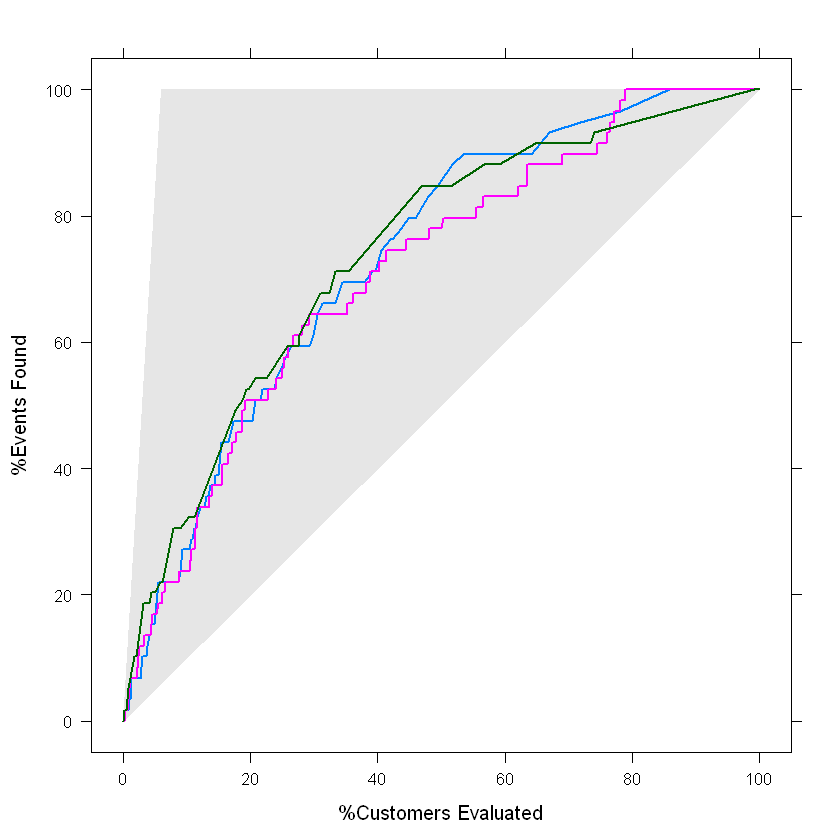

In [23]:
xyplot(lift_1,
       ylab = "%Events Found",
       xlab =  "%Customers Evaluated",
       lwd = 2,
       type = "l")

`ROC`

In [18]:
roc_lr <- roc(
              response = vld_result$CARAVAN,
              predictor = vld_result$LR,
              levels=rev(levels(vld_result$CARAVAN)))

roc_fda <- roc(
              response = vld_result$CARAVAN,
              predictor = vld_result$FDA,
              levels=rev(levels(vld_result$CARAVAN)))

roc_rf <- roc(
              response = vld_result$CARAVAN,
              predictor = vld_result$RF,
              levels=rev(levels(vld_result$CARAVAN)))

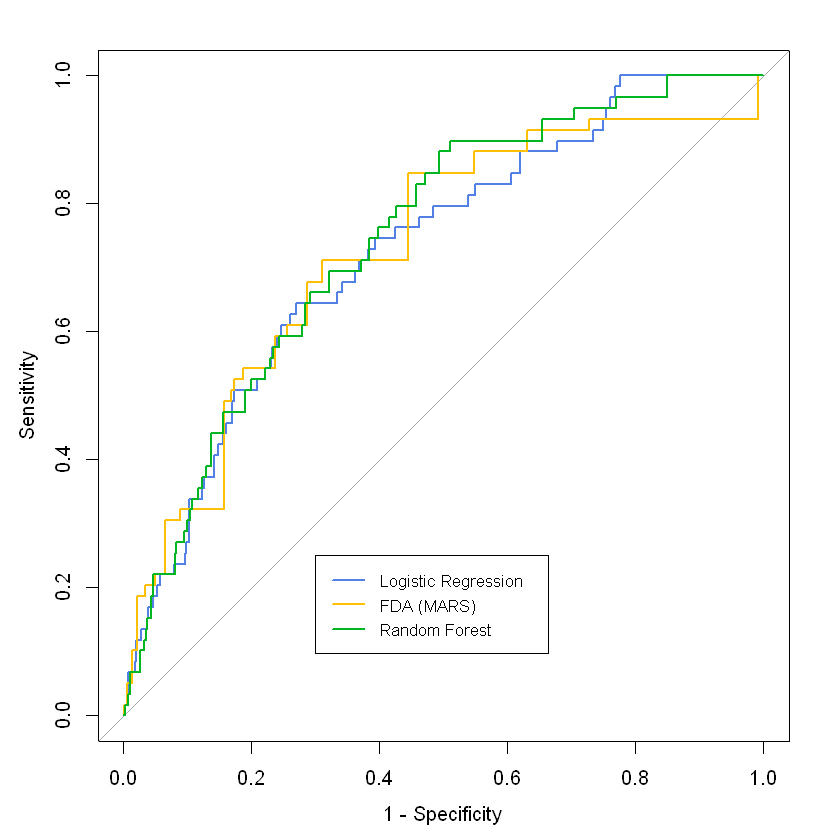

In [22]:
plotTheme <- caretTheme()

plot(roc_lr, type = "S", col = "#5380e4", legacy.axes = T)
plot(roc_fda, type = "S", col = "#ffbf03", add = TRUE, legacy.axes = T)
plot(roc_rf, type = "S", col = "#00b723", add = TRUE, legacy.axes = T)

legend(.7, .25,
       c("Logistic Regression", "FDA (MARS)","Random Forest"),
       cex = .85,
       col = c("#5380e4","#ffbf03","#00b723"),
       lwd = rep(2, 3),
       lty = rep(1, 3))

###  Alternate Cutoffs

In [30]:
# coords(smooth.roc, x, input=c("specificity",
# "sensitivity"), ret=c("specificity", "sensitivity"), as.list=FALSE,
# drop=TRUE, best.method=c("youden", "closest.topleft"), 
# best.weights=c(1, 0.5), ...)

In [36]:
library(pROC)
threshold_rf <- coords(roc_rf,x = "best",ret="threshold",best.method = "closest.topleft")
threshold_youden_rf <- coords(roc_rf,x = "best",ret="threshold",best.method = "youden")

cutText <- ifelse(threshold_rf==threshold_youden_rf,
                 "is the same as","is similar to")

vld_result$rfAlt <- factor(ifelse(vld_result$RF > threshold_rf,"insurance","noinsurance"))
cm_rfAlt_vld <- confusionMatrix(
                                reference = vld_result$CARAVAN,
                                data = vld_result$rfAlt)
cm_rfAlt_vld

Confusion Matrix and Statistics

             Reference
Prediction    insurance noinsurance
  insurance          41         297
  noinsurance        18         627
                                          
               Accuracy : 0.6796          
                 95% CI : (0.6494, 0.7087)
    No Information Rate : 0.94            
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1162          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.69492         
            Specificity : 0.67857         
         Pos Pred Value : 0.12130         
         Neg Pred Value : 0.97209         
             Prevalence : 0.06002         
         Detection Rate : 0.04171         
   Detection Prevalence : 0.34385         
      Balanced Accuracy : 0.68674         
                                          
       'Positive' Class : insurance       
                   

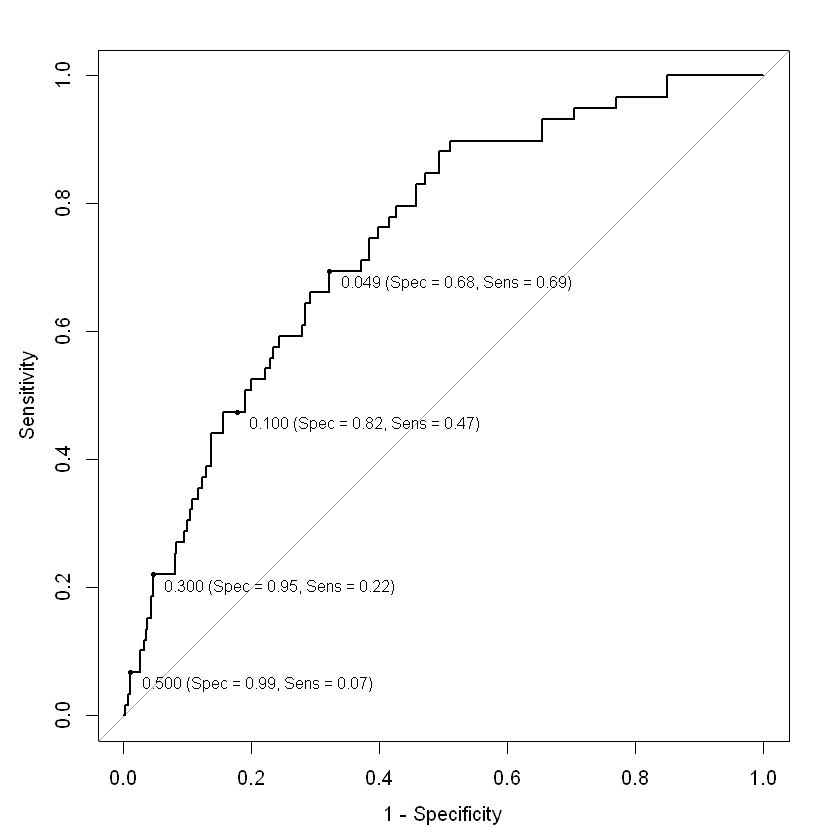

In [38]:
plot(roc_rf, print.thres = c(.5, .3, .10, threshold_rf), type = "S",
     print.thres.pattern = "%.3f (Spec = %.2f, Sens = %.2f)",
     print.thres.cex = .8, legacy.axes = TRUE)

In [41]:
cat("Original CM of tst set")
confusionMatrix(
                reference =  tst_result$CARAVAN,
                data = predict(fit_rf,newdata = tst_dum))

tst_result$RF <- predict(fit_rf,newdata = tst_dum,type="prob")[,1]
tst_result$rfAlt <- factor(ifelse(tst_result$RF > threshold_rf,"insurance","noinsurance"))

cm_rfAlt_tst <- confusionMatrix(
                                reference =  tst_result$CARAVAN,
                               data = tst_result$rfAlt)
cat("CM of tst set using Alternate Cutoffs")
cm_rfAlt_tst 

Original CM of tst set

Confusion Matrix and Statistics

             Reference
Prediction    insurance noinsurance
  insurance          11          19
  noinsurance       105        1827
                                          
               Accuracy : 0.9368          
                 95% CI : (0.9251, 0.9472)
    No Information Rate : 0.9409          
    P-Value [Acc > NIR] : 0.7935          
                                          
                  Kappa : 0.1295          
 Mcnemar's Test P-Value : 2.29e-14        
                                          
            Sensitivity : 0.094828        
            Specificity : 0.989707        
         Pos Pred Value : 0.366667        
         Neg Pred Value : 0.945652        
             Prevalence : 0.059123        
         Detection Rate : 0.005607        
   Detection Prevalence : 0.015291        
      Balanced Accuracy : 0.542268        
                                          
       'Positive' Class : insurance       
                   

CM of tst set using Alternate Cutoffs

Confusion Matrix and Statistics

             Reference
Prediction    insurance noinsurance
  insurance          77         556
  noinsurance        39        1290
                                         
               Accuracy : 0.6967         
                 95% CI : (0.6759, 0.717)
    No Information Rate : 0.9409         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1174         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.66379        
            Specificity : 0.69881        
         Pos Pred Value : 0.12164        
         Neg Pred Value : 0.97065        
             Prevalence : 0.05912        
         Detection Rate : 0.03925        
   Detection Prevalence : 0.32263        
      Balanced Accuracy : 0.68130        
                                         
       'Positive' Class : insurance      
                                      

### Adjusting Prior Probabilities

In [52]:
fit_fda$finalModel

Call:
mda::fda(formula = .outcome ~ ., data = dat, weights = wts, method = earth::earth, 
    degree = param$degree, nprune = param$nprune)

Dimension: 1 

Percent Between-Group Variance Explained:
 v1 
100 

Training Misclassification Error: 0.06224 ( N = 6877 )

In [53]:
priors <- table(ticdata$CARAVAN)/nrow(ticdata)*100
fdaPriors <- fdaFit
fdaPriors$finalModel$prior <- c(insurance = .6, noinsurance =  .4)
fdaPriorPred <- predict(fdaPriors, evaluation[,predictors])
evalResults$FDAprior <-  predict(fdaPriors, evaluation[,predictors], type = "prob")[,1]
testResults$FDAprior <-  predict(fdaPriors, testing[,predictors], type = "prob")[,1]
fdaPriorCM <- confusionMatrix(fdaPriorPred, evaluation$CARAVAN)
fdaPriorCM

fdaPriorROC <- roc(testResults$CARAVAN, testResults$FDAprior,
                   levels = rev(levels(testResults$CARAVAN)))
fdaPriorROC

In [56]:
cat("Prior Probabilities")
prop.table(table(ticdata$CARAVAN))

prior_fda <- fit_fda
prior_fda$finalModel$prior <- c(insurance = .6, noinsurance =  .4)

vld_result$FDAprior <- predict(prior_fda,vld,type="prob")[,1]
cm_fda_prior <- confusionMatrix(reference = vld_result$CARAVAN,
                               data = predict(prior_fda,newdata = vld))
cm_fda_prior
roc_fda_prior <- roc(
                     response = vld_result$CARAVAN,
                     predictor = vld_result$FDAprior,
                     levels=rev(levels(vld_result$CARAVAN)))
roc_fda_prior


Call:
roc.default(response = vld_result$CARAVAN, predictor = vld_result$FDAprior,     levels = rev(levels(vld_result$CARAVAN)))

Data: vld_result$FDAprior in 924 controls (vld_result$CARAVAN noinsurance) < 59 cases (vld_result$CARAVAN insurance).
Area under the curve: 0.7543

In [60]:
cm_fda_prior

cm_fda <- confusionMatrix(
                         reference = vld_result$CARAVAN,
                         data = predict(fit_fda,newdata = vld))

cm_fda

Confusion Matrix and Statistics

             Reference
Prediction    insurance noinsurance
  insurance          42         306
  noinsurance        17         618
                                          
               Accuracy : 0.6714          
                 95% CI : (0.6411, 0.7007)
    No Information Rate : 0.94            
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1156          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.71186         
            Specificity : 0.66883         
         Pos Pred Value : 0.12069         
         Neg Pred Value : 0.97323         
             Prevalence : 0.06002         
         Detection Rate : 0.04273         
   Detection Prevalence : 0.35402         
      Balanced Accuracy : 0.69035         
                                          
       'Positive' Class : insurance       
                   

Confusion Matrix and Statistics

             Reference
Prediction    insurance noinsurance
  insurance           1           3
  noinsurance        58         921
                                         
               Accuracy : 0.9379         
                 95% CI : (0.921, 0.9522)
    No Information Rate : 0.94           
    P-Value [Acc > NIR] : 0.638          
                                         
                  Kappa : 0.0243         
 Mcnemar's Test P-Value : 4.712e-12      
                                         
            Sensitivity : 0.016949       
            Specificity : 0.996753       
         Pos Pred Value : 0.250000       
         Neg Pred Value : 0.940756       
             Prevalence : 0.060020       
         Detection Rate : 0.001017       
   Detection Prevalence : 0.004069       
      Balanced Accuracy : 0.506851       
                                         
       'Positive' Class : insurance      
                                      

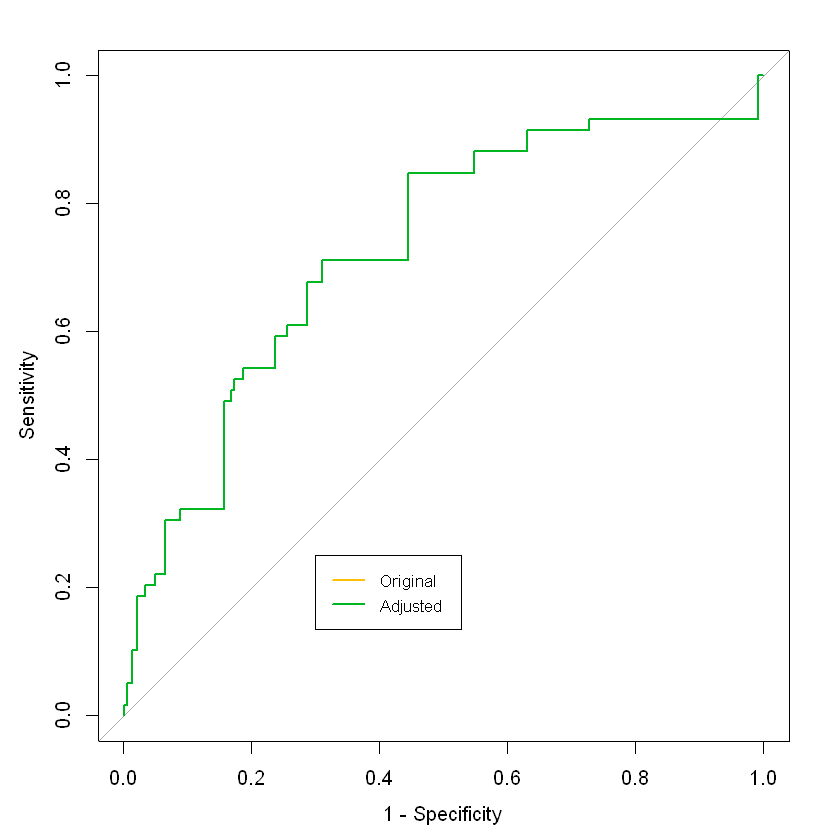

In [57]:
plot(roc_fda, type = "S", col = "#ffbf03", legacy.axes = T)
plot(roc_fda_prior, type = "S", col = "#00b723", add = T, legacy.axes = T)

legend(.7, .25,
       c("Original", "Adjusted"),
       cex = .85,
       col = c("#ffbf03","#00b723"),
       lwd = rep(2, 2),
       lty = rep(1, 2))